# **Deep Learning HW4 - Problem 2**
### **Ehsan Sharifian 400201529**

---

<div dir='rtl'> <font size='4'>
در حل این تمرین از سایت‌های زیر کمک اساسی گرفته شده و تقریبا کد آن‌ها تغییری نکرده است زیرا تمرین عیناً از روی آن‌ها داده شده بود:

https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

https://medium.com/analytics-vidhya/use-pytorch-to-create-an-image-captioning-model-with-cnn-and-seq2seq-lstm-and-train-on-google-e6563cb9f511
</font> </div>

## Download the required data 

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

from pycocotools.coco import COCO
import os 
import sys
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
import urllib
import zipfile 
import nltk
import pickle
import os.path
from collections import Counter
import torch.utils.data as data
from PIL import Image
from tqdm import tqdm
import random
import json
import math

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
os.makedirs('Image_Captioning' , exist_ok=True)
os.chdir( '/content/Image_Captioning' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [3]:
annotations_trainval = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
image_info_test = 'http://images.cocodataset.org/annotations/image_info_test2017.zip'

urllib.request.urlretrieve(annotations_trainval , filename = 'annotations_trainval2017.zip' )
urllib.request.urlretrieve(image_info_test , filename= 'image_info_test2017.zip' )

('image_info_test2017.zip', <http.client.HTTPMessage at 0x7f97cd754940>)

In [4]:
with zipfile.ZipFile('annotations_trainval2017.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/Image_Captioning/cocoapi'  )  

with zipfile.ZipFile('image_info_test2017.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/Image_Captioning/cocoapi'  )  

os.remove('annotations_trainval2017.zip')
os.remove('image_info_test2017.zip')

In [5]:
os.chdir('/content/Image_Captioning/cocoapi/annotations')

dataType = 'val2017'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

instances_val2017.json
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [7]:
os.chdir('/content/Image_Captioning/cocoapi')

train = 'http://images.cocodataset.org/zips/train2017.zip'
test = 'http://images.cocodataset.org/zips/test2017.zip'
val = 'http://images.cocodataset.org/zips/val2017.zip'

urllib.request.urlretrieve( train , 'train2017.zip' )
urllib.request.urlretrieve( test , 'test2017.zip' )
urllib.request.urlretrieve( val , 'val2017.zip' )

('val2017.zip', <http.client.HTTPMessage at 0x7f973a324100>)

In [8]:
with zipfile.ZipFile('train2017.zip','r') as zip_ref:
  zip_ref.extractall('images')

with zipfile.ZipFile('test2017.zip','r') as zip_ref:
  zip_ref.extractall('images')

with zipfile.ZipFile('val2017.zip','r') as zip_ref:
  zip_ref.extractall('images')

os.remove('train2017.zip')
os.remove('test2017.zip')
os.remove('val2017.zip')

## Step1: Making Vocabulary and DataLoader

### Vocabulary.py

In [9]:
class Vocabulary(object):
    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2017.json',
        vocab_from_file=False):

        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### data_loader.py

In [10]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/Image_Captioning'):
    
    if mode == 'train':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2017/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2017.json')
    if mode == 'test':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2017/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2017.json')

    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        else:
            path = self.paths[index]

            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

### Dataloader creation

In [11]:
!pip install nltk
import nltk
nltk.download('punkt')

transform_train = transforms.Compose([ 
    transforms.Resize((224,224)),                                             
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

vocab_threshold = 8

batch_size = 200

data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/Image_Captioning')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


100%|██████████| 591753/591753 [00:52<00:00, 11378.98it/s]


## Step 2: CNN Encoder



In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features


## Step 3: LSTM Decoder

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

## Step 4: Training

In [20]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 4
print_every = 150
save_every = 1 
embed_size = 256 

encoder = EncoderCNN( embed_size )
encoder.to(device)

vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )


device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Deep Learning/HW04/Q2/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )

Epochs [1/4] Step [0/2959] Loss [9.0278] 
Epochs [1/4] Step [150/2959] Loss [3.9016] 
Epochs [1/4] Step [300/2959] Loss [3.6298] 
Epochs [1/4] Step [450/2959] Loss [3.3569] 
Epochs [1/4] Step [600/2959] Loss [3.4029] 
Epochs [1/4] Step [750/2959] Loss [3.0927] 
Epochs [1/4] Step [900/2959] Loss [3.0340] 
Epochs [1/4] Step [1050/2959] Loss [2.9335] 
Epochs [1/4] Step [1200/2959] Loss [3.1132] 
Epochs [1/4] Step [1350/2959] Loss [3.2072] 
Epochs [1/4] Step [1500/2959] Loss [2.9415] 
Epochs [1/4] Step [1650/2959] Loss [2.9091] 
Epochs [1/4] Step [1800/2959] Loss [3.1306] 
Epochs [1/4] Step [1950/2959] Loss [3.0135] 
Epochs [1/4] Step [2100/2959] Loss [2.6800] 
Epochs [1/4] Step [2250/2959] Loss [2.5553] 
Epochs [1/4] Step [2400/2959] Loss [2.6510] 
Epochs [1/4] Step [2550/2959] Loss [2.7166] 
Epochs [1/4] Step [2700/2959] Loss [2.5733] 
Epochs [1/4] Step [2850/2959] Loss [2.7456] 
Epochs [2/4] Step [0/2959] Loss [2.3996] 
Epochs [2/4] Step [150/2959] Loss [2.4917] 
Epochs [2/4] Step [300/

KeyboardInterrupt: ignored

## Step 5: Testing

In [23]:
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                                    
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/Image_Captioning')

data_iter = iter(data_loader_test)

In [24]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

'a giraffe standing in a field with a tree .'

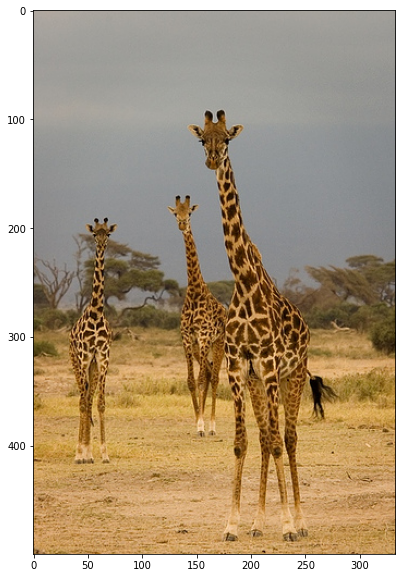

In [30]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.Predict( features  , max_len=20)
get_sentences(original_img, final_output)